# Portfolio Optimization using Multi-Angle Quantum Approximate Optimization Algorithm (QAOA), a small illustration of QiboOpt

## Portfolio Optimization (Budgeted Knapsack)

The **Portfolio Optimization Problem** can be stated as follows:

> Given expected returns for each asset and a covariance matrix capturing pairwise risks, we seek a subset of assets that maximizes expected return while respecting a budget or cardinality constraint and penalizing portfolio risk.

**Key Points:**

1. **Combinatorial Nature:** With N assets and a budget to pick k of them, there are "N choose k" possible portfolios; adding budget and risk penalties makes the search space grow rapidly.

2. **Risk-Return Trade-off:** The objective balances a linear reward term (expected return) against a quadratic penalty term (covariance risk). This naturally creates multiple Hamiltonian groups (reward, risk, constraints) that are well-suited to multi-angle QAOA.

3. **Applications:** Used in asset allocation, credit/bond selection, and feature selection framed as risk-aware knapsack problems.

4. **Optimization Goal:** Maximize expected return subject to a hard budget (or cardinality) while minimizing portfolio variance, typically modeled as a QUBO/Ising Hamiltonian.

5. **Why MA-QAOA helps:** Separate Hamiltonian groups (return vs risk vs constraints) can each receive their own phase angle; single-angle QAOA ties them together and often under- or over-penalizes constraints on small portfolios.


### Example instance

Below is a small 6-asset portfolio with expected returns and a covariance matrix; we ask QAOA to pick exactly 3 assets (cardinality constraint) while balancing return vs risk. Diagonal entries represent asset variance, or in other words, its inherent volatility. Non-diagonal entries represent assests' relationships with one another - larger entries suggest positive correlation, values close to 0 represent no correlation with negative values expressing a negative correlation.

$$
\mathbf{\Sigma} =
\begin{bmatrix}
0.040 & 0.018 & 0.012 & 0.010 & -0.005 & 0.009 \\
0.018 & 0.035 & 0.014 & 0.011 & 0.012 & -0.004 \\
0.012 & 0.014 & 0.030 & 0.013 & 0.010 & 0.011 \\
0.010 & 0.011 & 0.013 & 0.028 & 0.012 & 0.010 \\
-0.005 & 0.012 & 0.010 & 0.012 & 0.026 & 0.009 \\
0.009 & -0.004 & 0.011 & 0.010 & 0.009 & 0.024 \\
\end{bmatrix}
$$

Futher notes:

- Expected returns $\mu = [0.12,\ 0.10,\ 0.08,\ 0.07,\ 0.06,\ 0.05]$ (arbitrary units).
- Cardinality constraint: pick exactly $k = 3$ assets.
- Penalties: $\lambda_{	ext{risk}} = 1.0$, $\lambda_{	ext{budget}} = 6.0$ (tunable).


Let's visualise this:

In [1]:
# Code Imports

import numpy as np
import matplotlib.pyplot as plt
import qibo
from qibo import gates
from qibo.models.circuit import Circuit
from qibo.result import CircuitResult
from qiboopt.combinatorial.combinatorial import CombinatorialQAOA
from qiboopt.opt_class.opt_class import QUBO
from qibo.symbols import X, Z
from qibo.hamiltonians import SymbolicHamiltonian

GLOBAL_SEED = 13
np.random.seed(GLOBAL_SEED)
backend = qibo.get_backend()
backend.set_seed(GLOBAL_SEED)
rng = np.random.default_rng(GLOBAL_SEED)


[Qibo 0.2.21|INFO|2025-12-12 00:24:38]: Using numpy backend on /CPU:0


In [ ]:
# Problem setup

labels = ["A", "B", "C", "D", "E", "F"]
mu = np.array([0.12, 0.10, 0.08, 0.07, 0.06, 0.05])
cov = np.array([
    [0.040, 0.018, 0.012, 0.010, -0.005, 0.009],
    [0.018, 0.035, 0.014, 0.011, 0.012, -0.004],
    [0.012, 0.014, 0.030, 0.013, 0.010, 0.011],
    [0.010, 0.011, 0.013, 0.028, 0.012, 0.010],
    [-0.005, 0.012, 0.010, 0.012, 0.026, 0.009],
    [0.009, -0.004, 0.011, 0.010, 0.009, 0.024],
])
# mu = np.array([0.07, 0.06, 0.12, 0.13, 0.11, 0.04])
# cov = np.array([
#     [0.12 , 0.07 , 0.02 , 0.02 , 0.02 , 0.01 ],
#     [0.07 , 0.10 , 0.02 , 0.02 , 0.02 , 0.01 ],
#     [0.02 , 0.02 , 0.020, 0.010, 0.010, 0.005],
#     [0.02 , 0.02 , 0.010, 0.018, 0.010, 0.005],
#     [0.02 , 0.02 , 0.010, 0.010, 0.016, 0.005],
#     [0.01 , 0.01 , 0.005, 0.005, 0.005, 0.020],
# ])

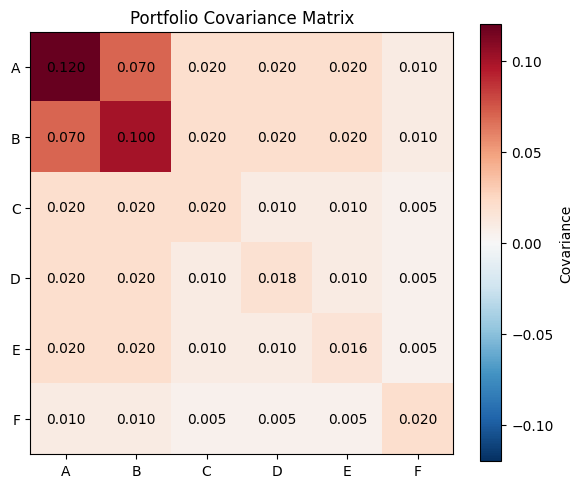

In [19]:
plt.figure(figsize=(6, 5))
plt.imshow(cov, cmap="RdBu_r", vmin=-np.max(np.abs(cov)), vmax=np.max(np.abs(cov)))
plt.xticks(range(len(labels)), labels)
plt.yticks(range(len(labels)), labels)
for i in range(cov.shape[0]):
    for j in range(cov.shape[1]):
        plt.text(j, i, f"{cov[i, j]:.3f}", ha="center", va="center", color="black")
plt.colorbar(label="Covariance")
plt.title("Portfolio Covariance Matrix")
plt.tight_layout()
plt.show()


## QUBO encoding for the portfolio
We maximize expected return while penalizing covariance risk and any violation of the budgeted cardinality (exactly k assets). Binary decision variables $x_i$ indicate whether asset $i$ is selected. The final QUBO is built from three parts:
- **Return reward:** linear bias that encourages picking assets with higher expected returns (sign flipped because QUBO is minimised).
- **Risk penalty:** quadratic term $x^T \Sigma x$ scaled by a risk-aversion factor.
- **Cardinality constraint:** $(\sum_i x_i - k)^2$ with a large penalty to enforce exactly $k$ picks.

The three Hamiltonian groups (return / risk / constraint) will later receive independent phase angles in a multi-angle QAOA layer.


In [20]:
# Build a QUBO with separated return / risk / cardinality pieces

k_budget = 3
return_weight = 1.0
risk_aversion = 0.6
penalty = 6  # start; raise to 12-16 if many infeasible samples, drop to 6-8 if over-penalized

n_assets = len(mu)

def build_portfolio_terms(mu, cov, budget, *, w_return=1.0, w_risk=0.6, penalty=8.0):
    # Reward term (negative sign because we minimize)
    return_q = {(i, i): -w_return * float(mu[i]) for i in range(len(mu))}

    # Risk term: x^T Sigma x with binary x -> diag + 2*off-diag
    risk_q = {}
    for i in range(len(mu)):
        risk_q[(i, i)] = risk_q.get((i, i), 0.0) + w_risk * float(cov[i, i])
        for j in range(i + 1, len(mu)):
            coeff = w_risk * 2.0 * float(cov[i, j])
            if coeff:
                risk_q[(i, j)] = risk_q.get((i, j), 0.0) + coeff

    # Cardinality constraint: (sum x_i - k)^2
    constr_q = {}
    constr_offset = penalty * (budget ** 2)
    diag = penalty * (1 - 2 * budget)
    for i in range(len(mu)):
        constr_q[(i, i)] = constr_q.get((i, i), 0.0) + diag
        for j in range(i + 1, len(mu)):
            constr_q[(i, j)] = constr_q.get((i, j), 0.0) + 2 * penalty

    return (
        QUBO(0.0, return_q),
        QUBO(0.0, risk_q),
        QUBO(constr_offset, constr_q),
    )

q_return, q_risk, q_constraint = build_portfolio_terms(
    mu,
    cov,
    k_budget,
    w_return=return_weight,
    w_risk=risk_aversion,
    penalty=penalty,
)
portfolio_qubo = q_return + q_risk + q_constraint

print(f"Assets: {n_assets}, budget k = {k_budget}")
print(f"Return biases (diag): {[q_return.Qdict[(i, i)] for i in range(n_assets)]}")
print(f"Penalty offset: {q_constraint.offset:.2f}")


Assets: 6, budget k = 3
Return biases (diag): [-0.07, -0.06, -0.12, -0.13, -0.11, -0.04]
Penalty offset: 54.00


In [21]:
# Greedy warm-start bitstring (top expected returns, ignores risk but respects budget)

top_indices = np.argsort(-mu)[:k_budget]
top_index_set = set(int(i) for i in top_indices)
greedy_bitstring = "".join("1" if i in top_index_set else "0" for i in range(n_assets))
print(f"Greedy warm start: {greedy_bitstring} -> {[labels[i] for i in sorted(top_index_set)]}")


Greedy warm start: 001110 -> ['C', 'D', 'E']


## MA-QAOA setup
We keep a simple transverse-field mixer and feed three cost Hamiltonians (return, risk, constraint) into the multi-angle helper so each layer learns separate angles per block. Two layers usually suffice for this toy instance.


In [22]:
def hamiltonian_from_qubo(qubo):
    return qubo.construct_symbolic_Hamiltonian_from_QUBO()

def x_mixer(n, backend=None):
    return SymbolicHamiltonian(sum(X(i) for i in range(n)), backend=backend)


class PortfolioProblem:
    def __init__(self, qubo, mixer=None):
        self.qubo = qubo
        self.cost_hamiltonian = hamiltonian_from_qubo(qubo)
        self.n = qubo.n
        backend = self.cost_hamiltonian.backend
        self.mixer_hamiltonian = mixer or x_mixer(self.n, backend=backend)

    def hamiltonians(self):
        return self.cost_hamiltonian, self.mixer_hamiltonian

    def prepare_initial_state(self, init="plus", bitstring=None):
        c = Circuit(self.n)
        if init == "plus":
            for i in range(self.n):
                c.add(gates.H(i))
        elif init == "bitstring":
            if bitstring is None:
                raise ValueError("Provide a bitstring when init='bitstring'.")
            bits = [int(b) for b in bitstring]
            if len(bits) != self.n:
                raise ValueError(f"Bitstring length must match n={self.n}.")
            for b in bits:
                if b not in (0, 1):
                    raise ValueError("Bitstring must contain only 0/1 entries.")
            for i, b in enumerate(bits):
                if b:
                    c.add(gates.X(i))
        else:
            raise ValueError("Only init='plus' or 'bitstring' supported in this demo.")
        result = self.cost_hamiltonian.backend.execute_circuit(c)
        return result.state()


# Individual Hamiltonian groups for MA-QAOA
ham_return = hamiltonian_from_qubo(q_return)
ham_risk = hamiltonian_from_qubo(q_risk)
ham_constraint = hamiltonian_from_qubo(q_constraint)

portfolio_problem = PortfolioProblem(portfolio_qubo)
p_layers = 3  # modest depth; bump to 4 if your backend allows
ma_default_angle = 0.05

ma_helper = CombinatorialQAOA(
    portfolio_problem,
    layers=p_layers,
    multi_angle=True,
    ma_cost_operators=[ham_return, ham_risk, ham_constraint],
    ma_mixer_operators=[portfolio_problem.mixer_hamiltonian],
    ma_default_angle=ma_default_angle,
)

total_angles = ma_helper._ma_total_angles
angle_bounds = [(-np.pi, np.pi)] * total_angles
optimizer_options = {"maxiter": 200, "ftol": 1e-6}
restart_seeds = [GLOBAL_SEED + i for i in range(4)]
state_choices = {
    "plus": {"init": "plus"},
    "warm_bitstring": {"init": "bitstring", "bitstring": greedy_bitstring},
}


def run_restart(state_kwargs, seed):
    backend.set_seed(seed)
    local_rng = np.random.default_rng(seed)
    base_angles = np.array(ma_helper._ma_default_angles(), dtype=float)
    jitter = local_rng.normal(0.0, 0.02, size=base_angles.shape)
    start_angles = np.clip(base_angles + jitter, -0.25, 0.25)
    energy, params, _ = ma_helper.minimize(
        initial_angles=start_angles.tolist(),
        state_kwargs=state_kwargs,
        method="L-BFGS-B",
        bounds=angle_bounds,
        options=optimizer_options,
    )
    return float(energy), params


best_runs = {}
for label, kwargs in state_choices.items():
    best_energy = np.inf
    best_params = None
    for seed in restart_seeds:
        energy, params = run_restart(kwargs, seed)
        if energy < best_energy:
            best_energy, best_params = energy, params
    best_runs[label] = {
        "energy": best_energy,
        "params": best_params,
        "state_kwargs": kwargs,
    }
    print(f"{label}: best penalized energy {best_energy:.4f} across {len(restart_seeds)} restarts")

best_label = min(best_runs, key=lambda key: best_runs[key]["energy"])
best_E = best_runs[best_label]["energy"]
params = best_runs[best_label]["params"]
best_state_kwargs = best_runs[best_label]["state_kwargs"]

print(f"Selected {best_label} parameters for sampling (energy={best_E:.4f}).")
print(f"MA parameter count: {len(params)}")


q:\..docs\...work\SIPGA\qiboopt\.venv\Lib\site-packages\scipy\_lib\array_api_compat\numpy\_aliases.py:125: ComplexWarning: Casting complex values to real discards the imaginary part
  return x.astype(dtype=dtype, copy=copy)
q:\..docs\...work\SIPGA\qiboopt\.venv\Lib\site-packages\scipy\optimize\_lbfgsb_py.py:442: ComplexWarning: Casting complex values to real discards the imaginary part
  x = array(x0, dtype=np.float64)


plus: best penalized energy 44.9725 across 4 restarts
warm_bitstring: best penalized energy 44.7968 across 4 restarts
Selected warm_bitstring parameters for sampling (energy=44.7968).
MA parameter count: 12


In [23]:
# Sample bitstrings from the MA-QAOA state and interpret them
state = ma_helper.execute(parameters=params, state_kwargs=best_state_kwargs)

c = Circuit(portfolio_qubo.n)
c.add(gates.M(*range(portfolio_qubo.n)))
nshots = 20_000
result = CircuitResult(state, c.measurements, ma_helper.cost_hamiltonian.backend, nshots=nshots)
freqs = result.frequencies()


def decode(bits):
    bits_vec = [int(b) for b in bits]
    picks = sum(bits_vec)
    ret = float(mu @ np.array(bits_vec))
    risk = float(np.array(bits_vec) @ cov @ np.array(bits_vec))
    net_obj = ret - risk_aversion * risk
    penalty_energy = penalty * (picks - k_budget) ** 2
    qubo_energy = portfolio_qubo.evaluate_f(bits_vec)
    assets = [labels[i] for i, b in enumerate(bits) if b == "1"]
    return picks, ret, risk, net_obj, penalty_energy, qubo_energy, assets


decoded = {bits: decode(bits) for bits in freqs}
row_total = sum(freqs.values())
feasible_shots = sum(count for bits, count in freqs.items() if decoded[bits][0] == k_budget)
feasible_ratio = feasible_shots / row_total if row_total else 0.0
print(f"Feasible samples: {feasible_ratio * 100:.1f}% at budget k={k_budget}")
if feasible_ratio < 0.8:
    print("Many infeasible samples; try raising penalty to 12-16.")
elif feasible_ratio > 0.98 and penalty > 6.0:
    print("Penalty might be high; you can try 6-8 to trade objective vs. feasibility.")

top_samples = sorted(freqs.items(), key=lambda kv: kv[1], reverse=True)[:5]
print("Top measured portfolios (bitstring -> stats)")
for bits, count in top_samples:
    picks, ret, risk, net_obj, penalty_energy, qubo_energy, assets = decoded[bits]
    print(
        f"{bits} | picks={picks} | count={count} | return={ret:.3f} | risk={risk:.3f} "
        f"| net={net_obj:.3f} | penalty={penalty_energy:.3f} | qubo={qubo_energy:.3f} | assets={assets}"
    )

init_label = best_state_kwargs["init"]
init_desc = "warm start" if init_label == "bitstring" else "|+> superposition"
print(f"Initial state used: {init_label} ({init_desc}).")

best_bits = top_samples[0][0] if top_samples else None


Feasible samples: 100.0% at budget k=3
Top measured portfolios (bitstring -> stats)
001110 | picks=3 | count=20000 | return=0.360 | risk=0.114 | net=0.292 | penalty=0.000 | qubo=-0.292 | assets=['C', 'D', 'E']
Initial state used: bitstring (warm start).


In [ ]:
# Repeat optimization + sampling multiple times to gather reliability data
num_passes = 3
batch_nshots = 20_000

batch_results = []
measure_circ = Circuit(portfolio_qubo.n)
measure_circ.add(gates.M(*range(portfolio_qubo.n)))

for pass_idx in range(num_passes):
    seed_shift = pass_idx * 100
    pass_best = {}
    for label, kwargs in state_choices.items():
        best_energy = np.inf
        best_params = None
        for seed in restart_seeds:
            energy, params = run_restart(kwargs, seed + seed_shift)
            if energy < best_energy:
                best_energy, best_params = energy, params
        pass_best[label] = {
            "energy": best_energy,
            "params": best_params,
            "state_kwargs": kwargs,
        }
    best_label = min(pass_best, key=lambda key: pass_best[key]["energy"])
    pass_energy = pass_best[best_label]["energy"]
    params = pass_best[best_label]["params"]
    state_kwargs = pass_best[best_label]["state_kwargs"]
    print(f"pass {pass_idx}: selected {best_label} with energy {pass_energy:.4f}")

    state = ma_helper.execute(parameters=params, state_kwargs=state_kwargs)
    result = CircuitResult(state, measure_circ.measurements, ma_helper.cost_hamiltonian.backend, nshots=batch_nshots)
    freqs = result.frequencies()
    decoded_batch = {bits: decode(bits) for bits in freqs}
    total = sum(freqs.values())
    feasible = sum(count for bits, count in freqs.items() if decoded_batch[bits][0] == k_budget)
    feasible_ratio = feasible / total if total else 0.0
    top_samples = sorted(freqs.items(), key=lambda kv: kv[1], reverse=True)[:3]
    print(f"pass {pass_idx}: feasible {feasible_ratio * 100:.1f}% (shots={total})")
    for bits, count in top_samples:
        stats = decoded_batch[bits]
        print(
            f"  {bits} | count={count} | picks={stats[0]} | net={stats[3]:.3f} | "
            f"penalty={stats[4]:.3f} | assets={stats[-1]}"
        )

    batch_results.append(
        {
            "pass": pass_idx,
            "label": best_label,
            "energy": pass_energy,
            "feasible_ratio": feasible_ratio,
            "top_samples": top_samples,
        }
    )

batch_results


pass 0: selected warm_bitstring with energy 44.7968
pass 0: feasible 100.0% (shots=20000)
  001110 | count=20000 | picks=3 | net=0.292 | penalty=0.000 | assets=['C', 'D', 'E']
pass 1: selected warm_bitstring with energy 44.7968
pass 1: feasible 100.0% (shots=20000)
  001110 | count=20000 | picks=3 | net=0.292 | penalty=0.000 | assets=['C', 'D', 'E']
pass 2: selected warm_bitstring with energy 44.7968
pass 2: feasible 100.0% (shots=20000)
  001110 | count=20000 | picks=3 | net=0.292 | penalty=0.000 | assets=['C', 'D', 'E']
pass 3: selected warm_bitstring with energy 44.7968
pass 3: feasible 100.0% (shots=20000)
  001110 | count=20000 | picks=3 | net=0.292 | penalty=0.000 | assets=['C', 'D', 'E']
pass 4: selected warm_bitstring with energy 44.7968
pass 4: feasible 100.0% (shots=20000)
  001110 | count=20000 | picks=3 | net=0.292 | penalty=0.000 | assets=['C', 'D', 'E']
pass 5: selected warm_bitstring with energy 44.7968
pass 5: feasible 100.0% (shots=20000)
  001110 | count=20000 | picks

[{'pass': 0,
  'label': 'warm_bitstring',
  'energy': 44.79679999999954,
  'feasible_ratio': 1.0,
  'top_samples': [('001110', 20000)]},
 {'pass': 1,
  'label': 'warm_bitstring',
  'energy': 44.79679999999958,
  'feasible_ratio': 1.0,
  'top_samples': [('001110', 20000)]},
 {'pass': 2,
  'label': 'warm_bitstring',
  'energy': 44.79679999999983,
  'feasible_ratio': 1.0,
  'top_samples': [('001110', 20000)]},
 {'pass': 3,
  'label': 'warm_bitstring',
  'energy': 44.79679999999957,
  'feasible_ratio': 1.0,
  'top_samples': [('001110', 20000)]},
 {'pass': 4,
  'label': 'warm_bitstring',
  'energy': 44.796799999999685,
  'feasible_ratio': 1.0,
  'top_samples': [('001110', 20000)]},
 {'pass': 5,
  'label': 'warm_bitstring',
  'energy': 44.79679999999974,
  'feasible_ratio': 1.0,
  'top_samples': [('001110', 20000)]},
 {'pass': 6,
  'label': 'warm_bitstring',
  'energy': 44.79679999999955,
  'feasible_ratio': 1.0,
  'top_samples': [('001110', 20000)]},
 {'pass': 7,
  'label': 'warm_bitstring'